Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import umap
from sklearn.preprocessing import StandardScaler

np.random.seed(1)

Variable Descriptions

In [2]:
# Mortgage              = Total Home Mortgage Balance Amount  
# Card Utilization      = Ratio of Credit Card balances to max limit 
# Amount Past Due       = Total Amount Past Due 

# Card Balance          = Overall Credit Card balances in current month 
# Card Balance_nm       = Overall Credit Card balances in the last n months

# Credit Inquiry        = Total number of inquiries made in current month
# Credit Inquiry_nm     = Total number of inquiries made in the last n months

# Open Trade*           = Total number of open trades presently satisfactory reported in current 
#                           month and trades are opened 12 months or older 
# Open Trade_nm         = Total number of open trades presently satisfactory reported in the last n 
#                           months and trades are opened 12 months or older 


# Delinquency Status    = Total number of trades ever derogatory including collections 
#                           (excluding satisfied medical collections) 
# Delinquency Status_nm = Total number of trades ever derogatory including collections (excluding 
#                           satisfied medical collections) in the last n months

# DDA Balance_9m        = Minimum DDA Balances with XYZ bank in last 9 months 
#                           DDA stands for Demand Deposit Accounts such as checking and saving accounts 

# Gender                = 1 if gender is Male and 0 else
# Race                  = 1 if race is White and 0 else
# Race Category         = Race by category 

# Status                = 1 Never delinquent or at most 29 consecutive days 
#                           past due in the last 24 months and 0 else

# WE HAVE NUMERIC, LAGGED NUMERIC, AND DEMOGRAPHIC DATA TO PERFORM BINARY CLASSIFICATION

EDA

In [3]:
data_dir = '../data'
raw, processed = 'raw', 'processed'

train_fname = 'train_PresSE_SRF_747.csv'

train = pd.read_csv(f'{data_dir}/{processed}/{train_fname}')

# re-ordering columns for better auto-visualization
cols = [
        'Mortgage', 'Card Utilization', 'Amount Past Due', 'DDA Balance_9m',
        'Card Balance', 'Card Balance_3m', 'Card Balance_6m', 'Card Balance_12m',
        'Delinquency Status', 'Delinquency Status_3m', 'Delinquency Status_6m', 'Delinquency Status_12m',
        'Credit Inquiry', 'Credit Inquiry_3m', 'Credit Inquiry_6m', 'Credit Inquiry_12m',
        'Open Trade', 'Open Trade_3m', 'Open Trade_6m', 'Open Trade_12m',
        'Gender', 'Race', 'Race_Category', 'Status'
    ]
train = train[cols]

In [4]:
train['Race_Category'].value_counts()

Race_Category
White       9088
Hispanic    6002
Black       2872
Asian       1080
Unknown      958
Name: count, dtype: int64

In [5]:
train[['Mortgage', 'Amount Past Due', 'DDA Balance_9m', 'Card Balance']].describe().T.iloc[:, 1:].round(2)

,mean,std,min,25%,50%,75%,max
Mortgage,222327.30,92847.40,108212.11,156268.62,194104.62,261449.09,1.207620e+06
Amount Past Due,100265.82,9999747.34,0.00,0.00,0.00,247.15,1.000000e+09
DDA Balance_9m,150772.66,12246826.96,0.00,0.00,0.00,0.00,1.000000e+09
Card Balance,1237.72,1295.86,2.02,382.33,818.48,1621.15,1.591293e+04


In [6]:
p = .995
for col_name in ('Amount Past Due', 'DDA Balance_9m'):
    print(f'{ round(p*100, 1) }th percentile for {col_name} is: { np.round( np.quantile(train[col_name], p), 2) }')

99.5th percentile for Amount Past Due is: 3934.19
99.5th percentile for DDA Balance_9m is: 10709.01


In [7]:
# Amount Past Due > $15k or DDA Balance_9m > $150K seems unreasonable give the 99.5 %ile values for both
train[(train['Amount Past Due'] > 1.5e4) | (train['DDA Balance_9m'] > 1.5e5)]

,Mortgage,Card Utilization,Amount Past Due,DDA Balance_9m,Card Balance,Card Balance_3m,Card Balance_6m,Card Balance_12m,Delinquency Status,Delinquency Status_3m,...,Credit Inquiry_6m,Credit Inquiry_12m,Open Trade,Open Trade_3m,Open Trade_6m,Open Trade_12m,Gender,Race,Race_Category,Status
134,330431.07,0.328861,1.000000e+09,0.000000e+00,797.61,1748.72,1803.21,2071.76,0,0,...,4,0,0,0,3,0,1,1,White,1
170,401534.88,0.970481,5.026500e+02,1.000000e+09,3382.68,3005.98,2912.31,2894.05,4,4,...,0,0,1,0,0,0,1,1,White,0
11837,143645.20,0.442902,0.000000e+00,1.000000e+09,163.08,112.44,97.79,128.33,0,0,...,0,7,0,0,0,1,0,0,Hispanic,0
16238,133074.36,0.907160,1.000000e+09,9.445400e+02,789.07,651.09,650.28,377.82,0,0,...,4,4,0,1,1,2,0,0,Black,1
19991,158506.34,0.127750,0.000000e+00,1.000000e+09,128.47,263.44,188.07,130.58,0,0,...,0,7,0,0,0,3,0,0,Unknown,1


In [8]:
# Sample train data includes amounts past due and DDA balances on the order of $1bn.
# Treating this as an error and removing these outliers.
train = train[~((train['Amount Past Due'] > 1.5e4) | (train['DDA Balance_9m'] > 1.5e5))]

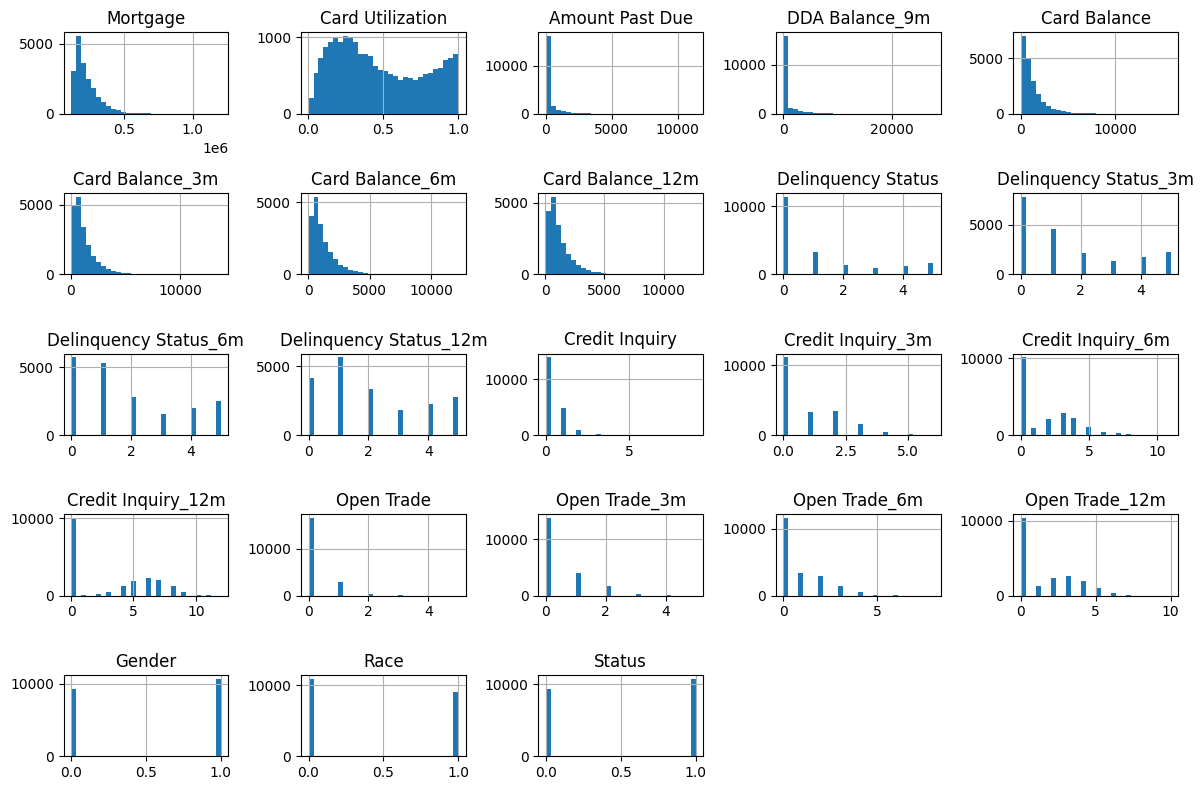

In [9]:
train.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

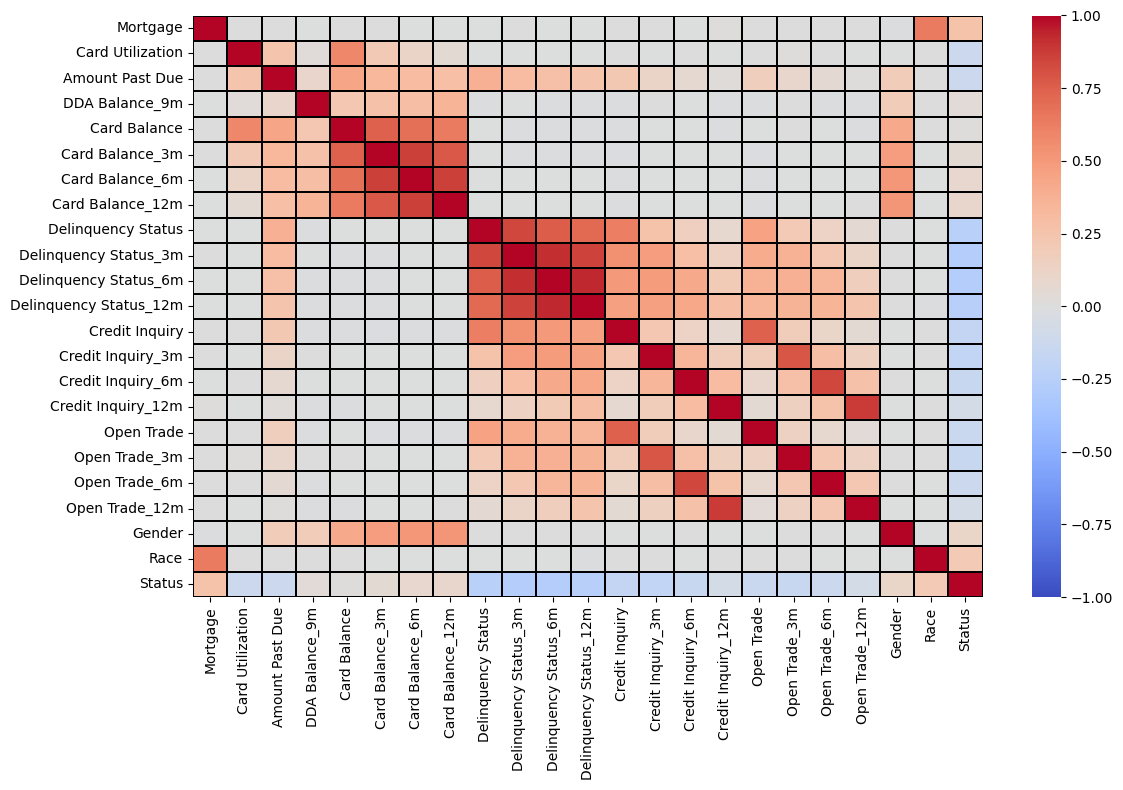

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap( train.drop('Race_Category', axis=1).corr(), cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.01, linecolor='black', ax=ax )

plt.tight_layout()
plt.show()

In [11]:
# Status (1, good) somewhat correlated with:
#   Race, Gender, Card Balance, DDA Balance_9m, Mortgage
#       => proxies for wealth and solvency

# Status (1, good) somewhat anticorrelated with:
#   Delinquency Status
#       => prior delinquency predicts future delinquency?

#   Credit Inquiry, Open Trade
#       => opening many different accounts to finance spending is an example of poor financial decision-making

#   Card Utilization, Amount Past Due
#       => person who makes poor financial decisions and uses their card for everything despite not being able to repay

# Interactions:
#   Race + Mortgage
#       => differences of wealth and geographic region by race influence mortgage payment

#   Gender + (Card Balance, DDA Balance_9m, Amount Past Due)
#       => wealth differences by gender (why does this affect amount past due?)

#   Delinquency Status + Credit Inquiry + Open Trade (+ respective lags)
#       => Open Trade and Credit Inquiry are obviously strongly correlated because opening a new account requires a credit check
#       => lagged terms have high correlation

#   Card Balance + (Card Utilization, Amount Past Due, DDA Balance_9m)
#       => if you use your card, you will have a higher balance
#       => probably two different groups of people with high balances: (1) wealthy via DDA Balance_9m; (2) not wealthy via Amount Past Due

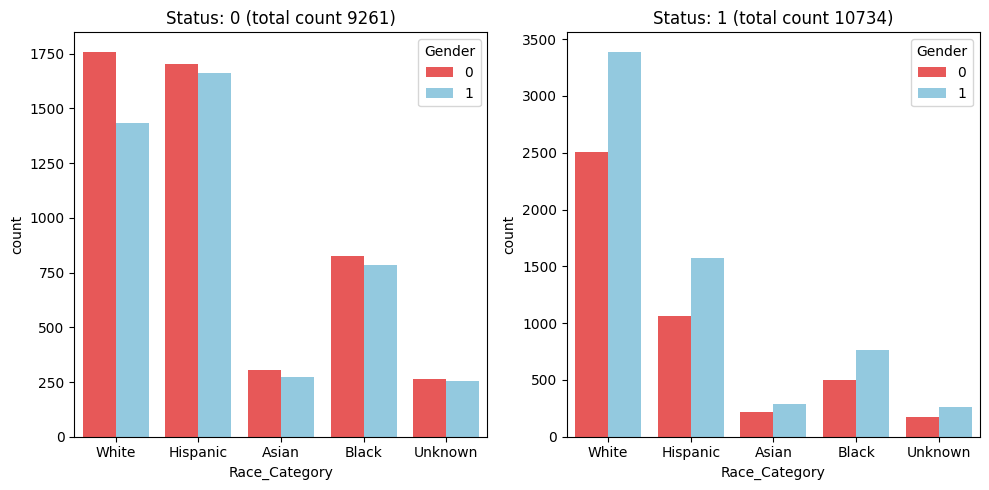

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for (i, g), ax in zip(train.groupby('Status'), axes.flatten()):
    sns.countplot(g, x='Race_Category', hue='Gender', palette=['#ff4040', '#87CEEB'], ax=ax)
    ax.set_title(f'Status: {i} (total count {len(g)})')

plt.tight_layout()
plt.show()

In [13]:
# Seems that the target labels are approximately evenly balanced.
# There is a bit of a gender imbalance in the sample of people with status label 1 (males over-represented in all race categories).

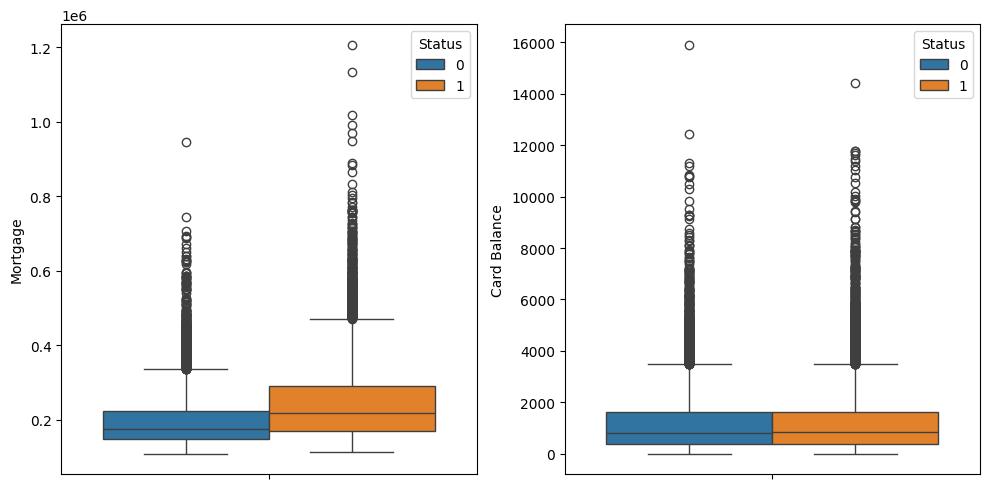

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(train, y='Mortgage', hue='Status', ax=ax[0])
sns.boxplot(train, y='Card Balance', hue='Status', ax=ax[1])

plt.tight_layout()
plt.show()

In [15]:
# Higher mortgage may be a proxy for wealth and thus impact credit status.
# A high card balance may also be a proxy for wealth. On the other hand, it can mean that a person is struggling to make payments.

In [16]:
# train[ ['Card Balance_12m', 'Card Balance_6m', 'Card Balance_3m', 'Card Balance'] ]
# train[ ['Credit Inquiry_12m', 'Credit Inquiry_6m', 'Credit Inquiry_3m', 'Credit Inquiry'] ]
# train[ ['Delinquency Status_12m', 'Delinquency Status_6m', 'Delinquency Status_3m', 'Delinquency Status'] ]
# train[ ['Open Trade_12m', 'Open Trade_6m', 'Open Trade_3m', 'Open Trade'] ]

def compute_trend(row, lagged_var_name):
    '''Checking if lags of a given variable for a given row (sample) 
    are decreasing and/or staying the same over time (versus increasing).'''
    
    curr_val = row[lagged_var_name]
    
    for lag in ('3', '6', '12'):
        col_name = f'{lagged_var_name}_{lag}m'
        prior_val = row[col_name]
        if prior_val < curr_val:
            # prior value was smaller, meaning there is an increase!
            return False
        curr_val = prior_val
    # did the lagged variable decrease (or at least stay the same)?
    return True

for col_name in ('Card Balance', 'Credit Inquiry', 'Open Trade'):
    train[f'{col_name}_Decreasing'] = train.apply(compute_trend, axis=1, lagged_var_name=col_name)

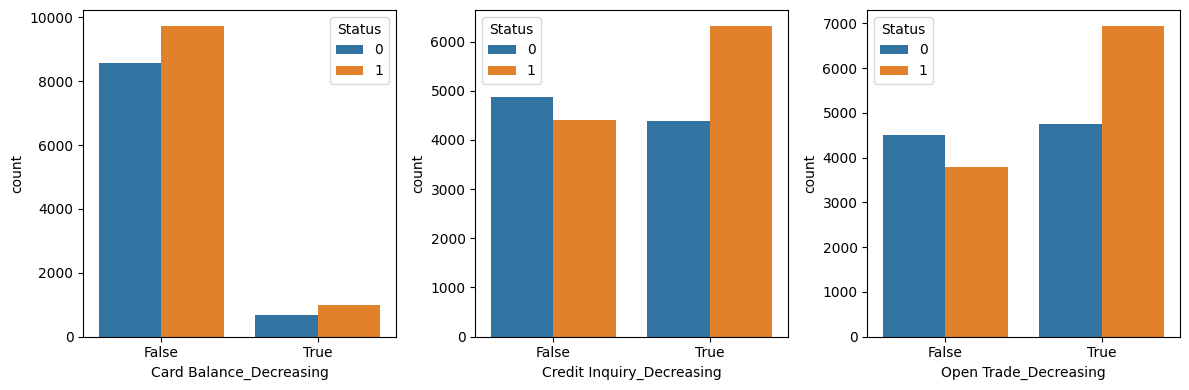

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for col_name, ax in zip(('Card Balance', 'Credit Inquiry', 'Open Trade'), axes.flatten()):
    sns.countplot(train, x=f'{col_name}_Decreasing', hue='Status', ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
# If there are fewer credit inquiries as well as accounts over time, perhaps a customer's financial situation is improving.
# However, if they are closing out their accounts, there is less of a chance to be delinquent (status of zero).

In [86]:
cols = ['Card Balance', 'Delinquency Status', 'Credit Inquiry', 'Open Trade', 'Card Utilization', 'Race', 'Gender', 'Mortgage']
umap_neighbors = 500
k = 2

# standardizing features to mean 0 and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train[cols])
# computing UMAP embedding
reducer = umap.UMAP(n_neighbors=umap_neighbors, n_components=k, metric='canberra', init='random', verbose=True)
embedding = reducer.fit_transform(X_scaled)

UMAP(init='random', metric='canberra', n_neighbors=500, verbose=True)
Sat Nov  4 11:47:15 2023 Construct fuzzy simplicial set
Sat Nov  4 11:47:15 2023 Finding Nearest Neighbors
Sat Nov  4 11:47:15 2023 Building RP forest with 12 trees
Sat Nov  4 11:47:16 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Sat Nov  4 11:47:37 2023 Finished Nearest Neighbor Search
Sat Nov  4 11:47:41 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Nov  4 11:47:49 2023 Finished embedding


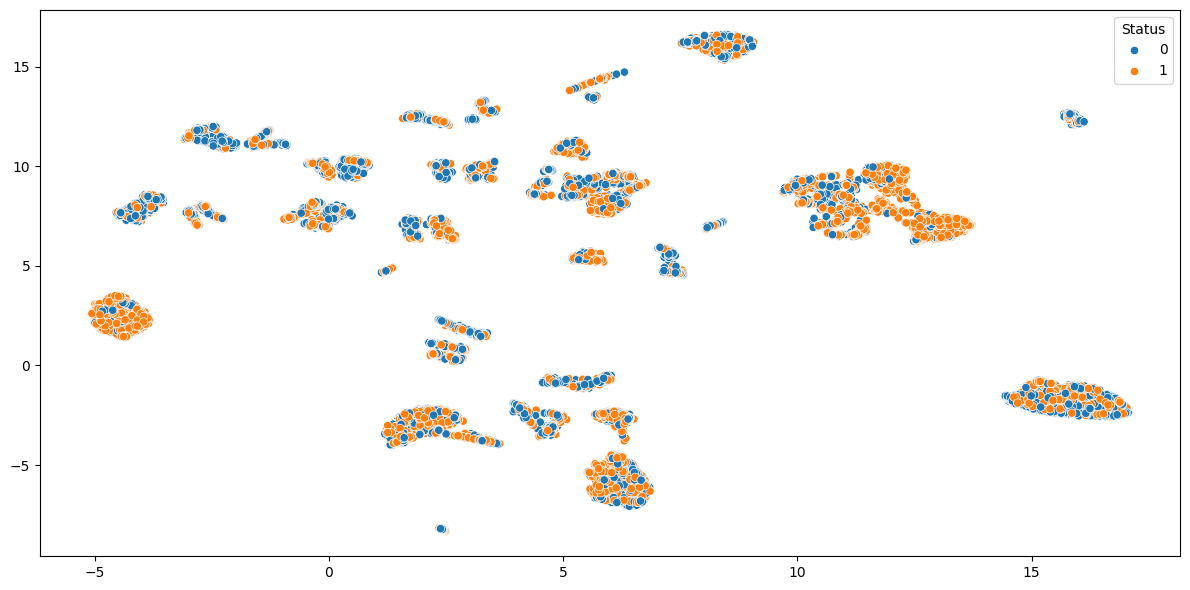

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=train['Status'])

plt.tight_layout()
plt.show()

In [ ]:
# Sanity check: we currently do not have good separation of the two classes based on features provided.